<a href="https://colab.research.google.com/github/Balajinanda/Large-Language-Models/blob/main/Text_Classification_of_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [82]:
pip install datasets

In [83]:
# Required libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from transformers import BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader

# **Loading the dataset**

In [108]:
# Load the TREC-6
TREC = load_dataset('trec')

# Inspect the dataset structure
print(TREC)

DatasetDict({
    train: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 5452
    })
    test: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 500
    })
})


# **Data Overview**

In [109]:
print(TREC['train'].features)

{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NUM:period', 'NUM:perc', 'NUM:speed', 'NUM:temp', 'NUM:volsize', 'NUM:weight'], id=None)}


In [110]:
print(TREC['test'].features)

{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NUM:period', 'NUM:perc', 'NUM:speed', 'NUM:temp', 'NUM:volsize', 'NUM:weight'], id=None)}


In [118]:
# Convert dataset to pandas DataFrame
train_trec = pd.DataFrame(TREC['train'])
test_trec = pd.DataFrame(TREC['test'])

# Print few rows
print(train_trec.head())
print(test_trec.head())

                                                text  coarse_label  fine_label
0  How did serfdom develop in and then leave Russ...             2          26
1   What films featured the character Popeye Doyle ?             1           5
2  How can I find a list of celebrities ' real na...             2          26
3  What fowl grabs the spotlight after the Chines...             1           2
4                    What is the full form of .com ?             0           1
                                       text  coarse_label  fine_label
0      How far is it from Denver to Aspen ?             5          40
1  What county is Modesto , California in ?             4          32
2                         Who was Galileo ?             3          31
3                         What is an atom ?             2          24
4          When did Hawaii become a state ?             5          39


# **EDA Analysis**

In [119]:
# Determine the frequency of each coarse label
train_label_counts = train_trec['coarse_label'].value_counts()
test_label_counts = test_trec['coarse_label'].value_counts()

# Get label names from the dataset
label_names = TREC['train'].features['coarse_label'].int2str

In [120]:
# Create a DataFrame for plotting
train_label_data = pd.DataFrame({
    'Label': train_label_counts.index.map(label_names),
    'Count': train_label_counts.values
})

# Plot the distribution of coarse labels in the training dataset
train_fig = px.bar(
    train_label_data,
    x='Label',
    y='Count',
    title='Coarse Label Distribution in Training Set',
    labels={'Count': 'Frequency', 'Label': 'Coarse Label'}
)
train_fig.update_layout(xaxis={'categoryorder': 'total descending'})

# Show the figure
train_fig.show()

In [121]:
# Create a DataFrame for plotting
test_label_data = pd.DataFrame({
    'Label': test_label_counts.index.map(label_names),
    'Count': test_label_counts.values
})

# Plot the distribution of coarse labels in the test dataset
test_fig = px.bar(
    test_label_data,
    x='Label',
    y='Count',
    title='Coarse Label Distribution in Test Set',
    labels={'Count': 'Frequency', 'Label': 'Coarse Label'}
)
test_fig.update_layout(xaxis={'categoryorder': 'total descending'})

# Show the figure
test_fig.show()

In [122]:
# Measure the length of each text entry by counting the words
train_trec['text_length'] = train_trec['text'].str.split().apply(len)
test_trec['text_length'] = test_trec['text'].str.split().apply(len)

# Get label names from the dataset
label_names = TREC['train'].features['coarse_label'].int2str

# Map label IDs to label names
train_trec['Label'] = train_trec['coarse_label'].map(label_names)
test_trec['Label'] = test_trec['coarse_label'].map(label_names)

In [123]:
# Create box plots for the training dataset
train_fig = px.box(
    train_trec,
    x='Label',
    y='text_length',
    title='Text Length Distribution by Coarse Label in Training Set',
    labels={'text_length': 'Text Length (Number of Tokens)', 'Label': 'Coarse Label'}
)
train_fig.update_layout(xaxis={'categoryorder': 'total ascending'})
train_fig.show()

In [124]:
# Create box plots for the test dataset
test_fig = px.box(
    test_trec,
    x='Label',
    y='text_length',
    title='Text Length Distribution by Coarse Label in Test Set',
    labels={'text_length': 'Text Length (Number of Tokens)', 'Label': 'Coarse Label'}
)
test_fig.update_layout(xaxis={'categoryorder': 'total ascending'})
test_fig.show()

# **Tokenization of dataset**

In [125]:
# Load the tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [126]:
# Define a tokenization function
def tokenize_function(example, tokenizer, padding='max_length', truncation=True, max_length=128):
    """
    Tokenizes the input text using the specified tokenizer.

    Parameters:
    - example: A dictionary containing the text to be tokenized.
    - tokenizer: The tokenizer to be used for tokenization.
    - padding: Type of padding to apply ('max_length', 'longest', or None).
    - truncation: Whether to truncate sequences to fit within the max_length.
    - max_length: The maximum length of sequences after padding/truncation.

    Returns:
    - A dictionary containing the tokenized input_ids, attention_mask, and token_type_ids.
    """
    return tokenizer(
        example['text'],
        padding=padding,
        truncation=truncation,
        max_length=max_length
    )

In [127]:
# Apply the tokenization function to your dataset
tokenized_datasets = TREC.map(lambda x: tokenize_function(x, tokenizer), batched=True)

# Remove the original text column
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Rename the labels column
tokenized_datasets = tokenized_datasets.rename_column("coarse_label", "labels")

# Set the format to PyTorch tensors
tokenized_datasets.set_format("torch")

In [128]:
# Inspect the first tokenized example in the training set
print(tokenized_datasets['train'][0])

{'labels': tensor(2), 'fine_label': tensor(26), 'input_ids': tensor([  101,  2129,  2106, 14262,  2546,  9527,  4503,  1999,  1998,  2059,
         2681,  3607,  1029,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [129]:
# Inspect the first tokenized example in the test set
print(tokenized_datasets['test'][0])

{'labels': tensor(5), 'fine_label': tensor(40), 'input_ids': tensor([  101,  2129,  2521,  2003,  2009,  2013,  7573,  2000, 18567,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [133]:
# Assuming 'tokenized_datasets' has been created as described earlier
training_dataset = tokenized_datasets['train']
testing_dataset = tokenized_datasets['test']

# Set up DataLoaders for batching
loader_train = DataLoader(dataset=training_dataset, batch_size=32, shuffle=True)
loader_test = DataLoader(dataset=testing_dataset, batch_size=32, shuffle=False)

# **Loading BERT Model**

In [134]:
# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Deploy the model to GPU if available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer with a specified learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



# **Training the model**

In [135]:
# Initialize lists to track metrics
training_losses = []
training_accuracies = []

# Set the number of epochs
num_epochs = 3

# Begin training loop
model.train()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    total_epoch_loss = 0
    correct_preds = 0
    total_samples = 0

    for batch in tqdm(loader_train):
        # Transfer batch to the designated device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Calculate the loss
        loss = outputs.loss
        total_epoch_loss += loss.item()

        # Backward pass for gradient calculation
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Calculate the number of correct predictions
        preds = torch.argmax(outputs.logits, dim=-1)
        correct_preds += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

    # Compute average loss and accuracy for the epoch
    avg_loss = total_epoch_loss / len(loader_train)
    epoch_accuracy = correct_preds / total_samples

    training_losses.append(avg_loss)
    training_accuracies.append(epoch_accuracy)

    print(f"Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch 1/3


100%|██████████| 171/171 [25:21<00:00,  8.90s/it]


Loss: 0.5507, Accuracy: 0.8125
Epoch 2/3


100%|██████████| 171/171 [25:08<00:00,  8.82s/it]


Loss: 0.1339, Accuracy: 0.9617
Epoch 3/3


100%|██████████| 171/171 [25:05<00:00,  8.81s/it]

Loss: 0.0567, Accuracy: 0.9815


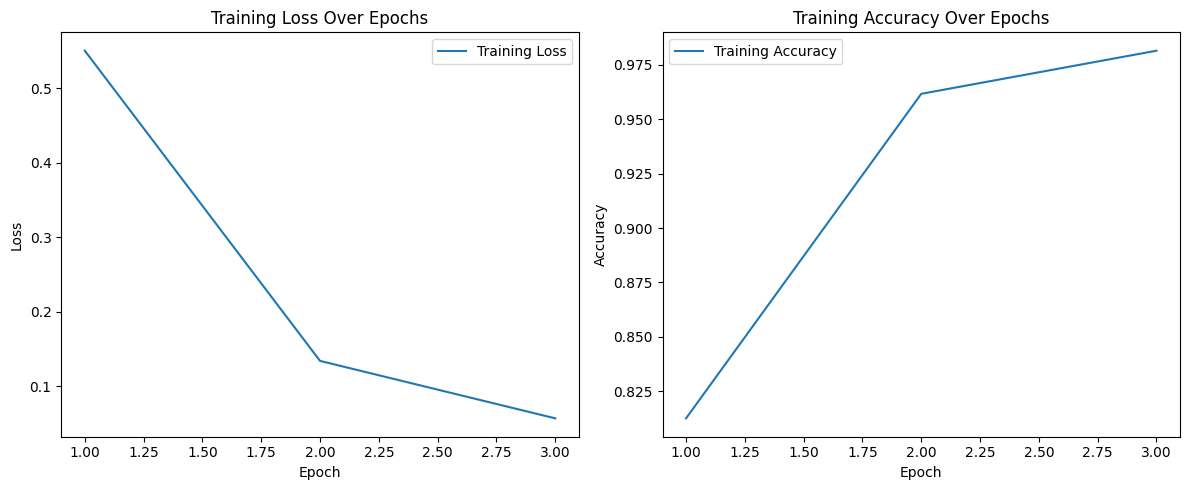

In [136]:
# Plotting accuracy and loss curves
def plot_training_curves(epochs, train_losses, train_accuracies):
    """
    Plots the training loss and accuracy curves.

    Parameters:
    - epochs: Number of epochs (int).
    - train_losses: List of loss values for each epoch.
    - train_accuracies: List of accuracy values for each epoch.
    """
    plt.figure(figsize=(12, 5))

    # Plotting the loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plotting the accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(num_epochs, training_losses, training_accuracies)

# **Model evaluation**

In [137]:
# Model Evaluation Phase
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in loader_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        # Collect predictions and true labels
        all_predictions.extend(preds.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9620


# **Results**

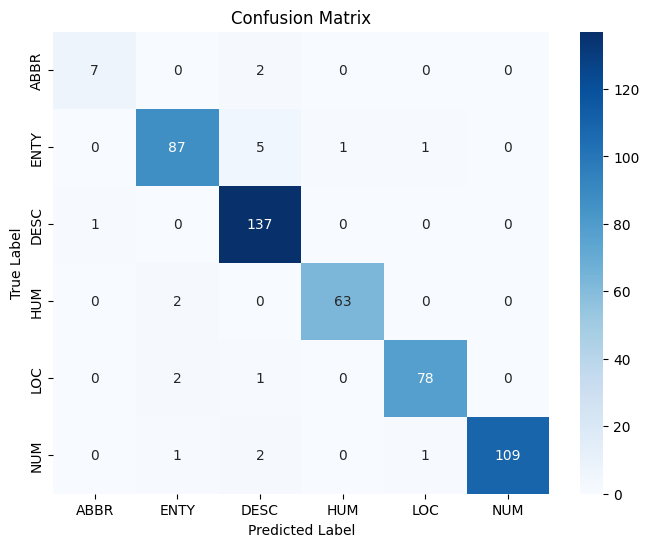

In [138]:
# Ensure label_names contains the correct label names
label_names = TREC['train'].features['coarse_label'].names

# Create the confusion matrix
confusion_mat = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [139]:
# Produce the classification report
report = classification_report(all_true_labels, all_predictions, target_names=label_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        ABBR       0.88      0.78      0.82         9
        ENTY       0.95      0.93      0.94        94
        DESC       0.93      0.99      0.96       138
         HUM       0.98      0.97      0.98        65
         LOC       0.97      0.96      0.97        81
         NUM       1.00      0.96      0.98       113

    accuracy                           0.96       500
   macro avg       0.95      0.93      0.94       500
weighted avg       0.96      0.96      0.96       500



# **Example predictions**

In [140]:
# Function to select and print predictions for random samples from the test set
def display_random_predictions(model, tokenizer, tokenized_dataset, label_names, device, num_samples=5):
    """
    Randomly selects samples from the test set, predicts using the model, and displays the results.

    Parameters:
    - model: The trained BERT model.
    - tokenizer: The tokenizer used for text preprocessing.
    - tokenized_dataset: The tokenized dataset for testing.
    - label_names: List of label names associated with label IDs.
    - device: The device to run computations on (e.g., 'cpu' or 'cuda').
    - num_samples: Number of random samples to select for prediction (default is 5).
    """
    # Randomly select indices from the test set
    random_indices = random.sample(range(len(tokenized_dataset)), num_samples)

    # Switch the model to evaluation mode
    model.eval()

    for index in random_indices:
        # Retrieve input data for the selected sample
        input_ids = tokenized_dataset['input_ids'][index].unsqueeze(0).to(device)
        attention_mask = tokenized_dataset['attention_mask'][index].unsqueeze(0).to(device)

        # Get the true label for the sample
        true_label_id = tokenized_dataset['labels'][index].item()
        true_label = label_names[true_label_id]

        # Perform prediction
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted_label_id = torch.argmax(outputs.logits, dim=-1).item()
            predicted_label = label_names[predicted_label_id]

        # Decode the original text and print the results
        original_text = tokenizer.decode(tokenized_dataset['input_ids'][index], skip_special_tokens=True)
        print(f"Original Text: {original_text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {predicted_label}\n")

# Call the function to display random predictions
display_random_predictions(model, tokenizer, tokenized_datasets['test'], label_names, device, num_samples=5)

Original Text: who is the actress known for her role in the movie ` ` gypsy''?
True Label: HUM
Predicted Label: HUM

Original Text: what is the population of nigeria?
True Label: NUM
Predicted Label: NUM

Original Text: what is cryogenics?
True Label: DESC
Predicted Label: DESC

Original Text: what is viscosity?
True Label: DESC
Predicted Label: DESC

Original Text: what is die - casting?
True Label: DESC
Predicted Label: DESC

